# Задание 2: Эксперименты с шириной сети

Загрузчик датасетов

In [2]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.MNIST(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


class CIFARDataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = torchvision.datasets.CIFAR10(
            root='./data', 
            train=train, 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]


def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = MNISTDataset(train=True, transform=transform)
    test_dataset = MNISTDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


def get_cifar_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    train_dataset = CIFARDataset(train=True, transform=transform)
    test_dataset = CIFARDataset(train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader 

Создание модели по конфигурациям

In [3]:
import torch
import torch.nn as nn
import json

class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()
        
        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        """
        Загружает конфигурацию из JSON файла
        """
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            match layer_type:
                case 'linear':
                    out_size = layer_spec['size']
                    layers.append(nn.Linear(prev_size, out_size))
                    prev_size = out_size

                case 'relu':
                    layers.append(nn.ReLU())

                case 'sigmoid':
                    layers.append(nn.Sigmoid())

                case 'tanh':
                    layers.append(nn.Tanh())

                case 'dropout':
                    rate = layer_spec.get('rate', 0.5)
                    layers.append(nn.Dropout(rate))

                case 'batch_norm':
                    layers.append(nn.BatchNorm1d(prev_size))

                case 'layer_norm':
                    layers.append(nn.LayerNorm(prev_size))

                case _:
                    raise ValueError(f"Неизвестный тип слоя: {layer_type}")

        # Всегда добавляем финальный слой для классификации
        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # "выпрямляем" картинку в вектор
        return self.layers(x)

Обучение модели

In [4]:
def run_epoch(model, data_loader, criterion, optimizer = None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)
        
        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    return total_loss / len(data_loader), correct / total

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    } 

Создание графиков и Сохранение/загрузка модели

In [5]:
import torch
import matplotlib.pyplot as plt
import os

def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.legend()
    
    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    plt.tight_layout()


def count_parameters(model):
    """Подсчитывает количество параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_model(
        path: str, 
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        epoch: int, 
        best_test_loss: float, 
        best_test_acc: float
    ):
    state_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'best_test_loss': best_test_loss,
        'best_test_acc': best_test_acc
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state_dict, path)


def load_model(path: str, model: torch.nn.Module, optimizer: torch.optim.Optimizer):
    state_dict = torch.load(path)
    model.load_state_dict(state_dict['model'])
    optimizer.load_state_dict(state_dict['optimizer'])
    return state_dict['epoch'], state_dict['best_test_loss'], state_dict['best_test_acc']

# 2.1 Сравнение моделей разной ширины

Наборы конфигураций(Различной ширины, но одинаковой размерностью)

In [6]:

# Мне удобнее словарь создать, чем под каждую новую модель создавать json с конфигами
# Узкие слои: [64, 32, 16]
config_small_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
#Средние слои: [256, 128, 64]
config_medium_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}

# Широкие слои: [1024, 512, 256]
config_big_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
# Очень широкие слои: [2048, 1024, 512]
config_very_big_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 512},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 256},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}
# До этого все архитектуры были на сужение количества нейронов в слое, сейчас создадим также равномерную и расширяющуюся
# архитектуры


# Равномерные

config_evenly_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 784},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 784},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}


# Расширяющиеся
config_extension_layer = {
    "input_size": 784,
    "num_classes": 10,
    "layers": [
        {"type": "linear", "size": 1448},
        {"type": "relu"},
        {"type": "batch_norm"},

        {"type": "linear", "size": 2896},
        {"type": "relu"},
        {"type": "dropout", "rate": 0.4}
    ]
}

Запускаем модель Узкие слои

Model parameters: 536842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 26.01it/s]


Epoch 1/10:
Train Loss: 0.2217, Train Acc: 0.9331
Test Loss: 0.1083, Test Acc: 0.9655
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.29it/s]


Epoch 2/10:
Train Loss: 0.1187, Train Acc: 0.9637
Test Loss: 0.1207, Test Acc: 0.9706
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.28it/s]


Epoch 3/10:
Train Loss: 0.0901, Train Acc: 0.9717
Test Loss: 0.0970, Test Acc: 0.9764
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.75it/s]


Epoch 4/10:
Train Loss: 0.0759, Train Acc: 0.9767
Test Loss: 0.1410, Test Acc: 0.9774
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch 5/10:
Train Loss: 0.0656, Train Acc: 0.9794
Test Loss: 0.1102, Test Acc: 0.9785
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.16it/s]


Epoch 6/10:
Train Loss: 0.0555, Train Acc: 0.9821
Test Loss: 0.2288, Test Acc: 0.9769
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.11it/s]


Epoch 7/10:
Train Loss: 0.0507, Train Acc: 0.9836
Test Loss: 0.1303, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.61it/s]


Epoch 8/10:
Train Loss: 0.0466, Train Acc: 0.9848
Test Loss: 0.0881, Test Acc: 0.9790
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.59it/s]


Epoch 9/10:
Train Loss: 0.0405, Train Acc: 0.9865
Test Loss: 0.1017, Test Acc: 0.9791
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.88it/s]


Epoch 10/10:
Train Loss: 0.0401, Train Acc: 0.9869
Test Loss: 0.1185, Test Acc: 0.9816
--------------------------------------------------
{'train_losses': [0.2217403438105099, 0.11874887329051649, 0.0900917268241011, 0.07592187999541174, 0.06555907491486329, 0.05547380452910597, 0.050685367534688705, 0.04655334035880111, 0.040526205433164236, 0.04014880361712115], 'train_accs': [0.93305, 0.9636666666666667, 0.9717166666666667, 0.9767166666666667, 0.9794, 0.98215, 0.9835833333333334, 0.98475, 0.9864833333333334, 0.98685], 'test_losses': [0.10826743434548117, 0.120693792458505, 0.09698418843330797, 0.140972778473465, 0.11015147245905227, 0.22879393104173518, 0.1303046964402114, 0.08813042230920785, 0.10171466247718935, 0.11849354186582856], 'test_accs': [0.9655, 0.9706, 0.9764, 0.9774, 0.9785, 0.9769, 0.9779, 0.979, 0.9791, 0.9816]}
475.87869596481323


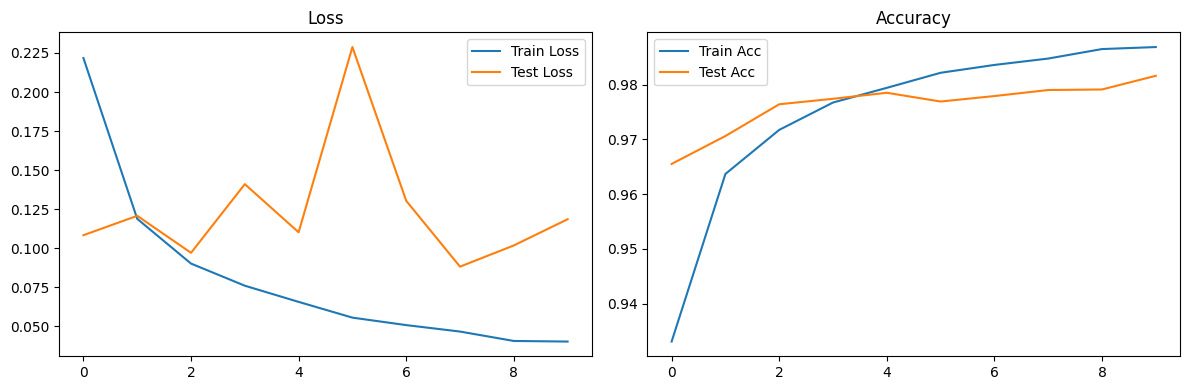

In [7]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_mnist_loaders(batch_size=64)

#Выбираем один из наборов конфигураций модели
model = FullyConnectedModel(config_path=None, **config_small_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель Средние слои

Model parameters: 536842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.61it/s]


Epoch 1/10:
Train Loss: 0.2200, Train Acc: 0.9339
Test Loss: 0.1216, Test Acc: 0.9619
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.70it/s]


Epoch 2/10:
Train Loss: 0.1174, Train Acc: 0.9644
Test Loss: 0.0868, Test Acc: 0.9722
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.29it/s]


Epoch 3/10:
Train Loss: 0.0908, Train Acc: 0.9716
Test Loss: 0.1062, Test Acc: 0.9722
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.81it/s]


Epoch 4/10:
Train Loss: 0.0771, Train Acc: 0.9760
Test Loss: 0.0954, Test Acc: 0.9740
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.53it/s]


Epoch 5/10:
Train Loss: 0.0638, Train Acc: 0.9795
Test Loss: 0.0843, Test Acc: 0.9778
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.66it/s]


Epoch 6/10:
Train Loss: 0.0563, Train Acc: 0.9817
Test Loss: 0.1290, Test Acc: 0.9773
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.90it/s]


Epoch 7/10:
Train Loss: 0.0496, Train Acc: 0.9840
Test Loss: 0.2436, Test Acc: 0.9766
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.85it/s]


Epoch 8/10:
Train Loss: 0.0462, Train Acc: 0.9845
Test Loss: 0.1198, Test Acc: 0.9786
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.62it/s]


Epoch 9/10:
Train Loss: 0.0414, Train Acc: 0.9866
Test Loss: 0.1452, Test Acc: 0.9802
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.31it/s]


Epoch 10/10:
Train Loss: 0.0393, Train Acc: 0.9862
Test Loss: 0.1356, Test Acc: 0.9798
--------------------------------------------------
{'train_losses': [0.21998492733184208, 0.11743328490975632, 0.09081516279402112, 0.07711064522025554, 0.0638342010120907, 0.05629329627473106, 0.049621127635813445, 0.04619294951341228, 0.041389107693985565, 0.0392519326602009], 'train_accs': [0.9339, 0.9643833333333334, 0.9716, 0.9760333333333333, 0.9795333333333334, 0.98165, 0.984, 0.9845166666666667, 0.9865833333333334, 0.9862333333333333], 'test_losses': [0.1215566283642095, 0.08675624479081447, 0.10624045103680488, 0.09538178967823056, 0.08431156359391975, 0.1289976457048895, 0.24356962345288136, 0.11983477556907692, 0.14517173960114046, 0.13555718501112288], 'test_accs': [0.9619, 0.9722, 0.9722, 0.974, 0.9778, 0.9773, 0.9766, 0.9786, 0.9802, 0.9798]}
433.31148624420166


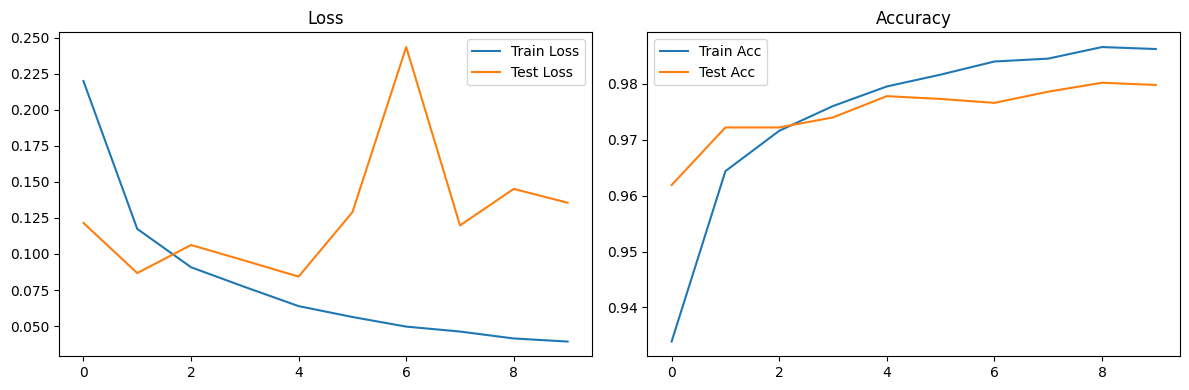

In [8]:
model = FullyConnectedModel(config_path=None, **config_medium_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель Большие слои

Model parameters: 536842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.98it/s]


Epoch 1/10:
Train Loss: 0.2213, Train Acc: 0.9328
Test Loss: 0.1221, Test Acc: 0.9653
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.35it/s]


Epoch 2/10:
Train Loss: 0.1160, Train Acc: 0.9645
Test Loss: 0.1069, Test Acc: 0.9683
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.64it/s]


Epoch 3/10:
Train Loss: 0.0883, Train Acc: 0.9728
Test Loss: 0.1776, Test Acc: 0.9754
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.78it/s]


Epoch 4/10:
Train Loss: 0.0745, Train Acc: 0.9766
Test Loss: 0.1075, Test Acc: 0.9757
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.15it/s]


Epoch 5/10:
Train Loss: 0.0665, Train Acc: 0.9794
Test Loss: 0.0982, Test Acc: 0.9782
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.24it/s]


Epoch 6/10:
Train Loss: 0.0542, Train Acc: 0.9828
Test Loss: 0.1082, Test Acc: 0.9797
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.79it/s]


Epoch 7/10:
Train Loss: 0.0502, Train Acc: 0.9831
Test Loss: 0.0808, Test Acc: 0.9814
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.54it/s]


Epoch 8/10:
Train Loss: 0.0450, Train Acc: 0.9849
Test Loss: 0.1231, Test Acc: 0.9795
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.21it/s]


Epoch 9/10:
Train Loss: 0.0402, Train Acc: 0.9870
Test Loss: 0.1708, Test Acc: 0.9798
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.19it/s]


Epoch 10/10:
Train Loss: 0.0372, Train Acc: 0.9876
Test Loss: 0.1793, Test Acc: 0.9814
--------------------------------------------------
{'train_losses': [0.22131537768973916, 0.11598509223535974, 0.08825653281285246, 0.07454716305939485, 0.06648133134768247, 0.054153110337024656, 0.05019730499935404, 0.044951364224620746, 0.04018430728178624, 0.037166640206418466], 'train_accs': [0.9328333333333333, 0.9645333333333334, 0.97285, 0.9766, 0.9793833333333334, 0.9828333333333333, 0.9830666666666666, 0.9849166666666667, 0.9870166666666667, 0.9875666666666667], 'test_losses': [0.12211813712136665, 0.10687754327204423, 0.17757001264294414, 0.1074830467781574, 0.09820171101135572, 0.10820815025198598, 0.08081786477542797, 0.12308029503808152, 0.1708335549255993, 0.17925044347292937], 'test_accs': [0.9653, 0.9683, 0.9754, 0.9757, 0.9782, 0.9797, 0.9814, 0.9795, 0.9798, 0.9814]}
446.344753742218


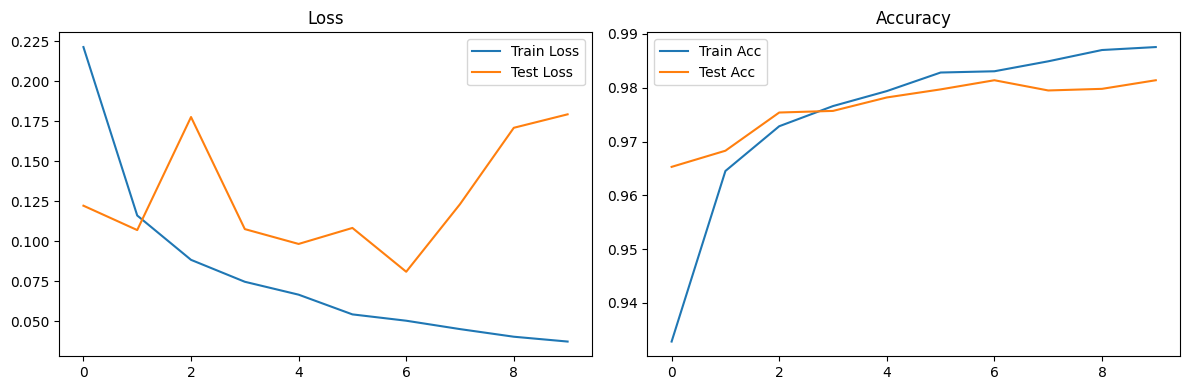

In [9]:
model = FullyConnectedModel(config_path=None, **config_big_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Запускаем модель Очень большие слои

Model parameters: 536842


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.28it/s]


Epoch 1/10:
Train Loss: 0.2209, Train Acc: 0.9340
Test Loss: 0.1223, Test Acc: 0.9642
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.62it/s]


Epoch 2/10:
Train Loss: 0.1171, Train Acc: 0.9640
Test Loss: 0.0963, Test Acc: 0.9725
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.33it/s]


Epoch 3/10:
Train Loss: 0.0877, Train Acc: 0.9725
Test Loss: 0.1055, Test Acc: 0.9739
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.14it/s]


Epoch 4/10:
Train Loss: 0.0791, Train Acc: 0.9750
Test Loss: 0.0772, Test Acc: 0.9767
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.79it/s]


Epoch 5/10:
Train Loss: 0.0628, Train Acc: 0.9798
Test Loss: 0.1356, Test Acc: 0.9731
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.34it/s]


Epoch 6/10:
Train Loss: 0.0566, Train Acc: 0.9817
Test Loss: 0.1079, Test Acc: 0.9779
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.66it/s]


Epoch 7/10:
Train Loss: 0.0517, Train Acc: 0.9836
Test Loss: 0.2746, Test Acc: 0.9778
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 36.17it/s]


Epoch 8/10:
Train Loss: 0.0469, Train Acc: 0.9851
Test Loss: 0.0990, Test Acc: 0.9781
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.38it/s]


Epoch 9/10:
Train Loss: 0.0414, Train Acc: 0.9868
Test Loss: 0.0796, Test Acc: 0.9808
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.73it/s]


Epoch 10/10:
Train Loss: 0.0391, Train Acc: 0.9872
Test Loss: 0.1854, Test Acc: 0.9803
--------------------------------------------------
{'train_losses': [0.22090304496962188, 0.11714248770504379, 0.08770550473251625, 0.07911081422171963, 0.06284213161678302, 0.056622461914998305, 0.05167552734558125, 0.04693523979200217, 0.04138714330749207, 0.03910147609430671], 'train_accs': [0.9340166666666667, 0.9639833333333333, 0.9725, 0.97505, 0.97985, 0.9816833333333334, 0.9836333333333334, 0.9851333333333333, 0.98675, 0.9872333333333333], 'test_losses': [0.12233367418888126, 0.09626846602701902, 0.10549071405930474, 0.07721395916437099, 0.13561348356634667, 0.10793681682511665, 0.2746352584381268, 0.09901042981861102, 0.07956353571113418, 0.18544364093667107], 'test_accs': [0.9642, 0.9725, 0.9739, 0.9767, 0.9731, 0.9779, 0.9778, 0.9781, 0.9808, 0.9803]}
438.22490763664246


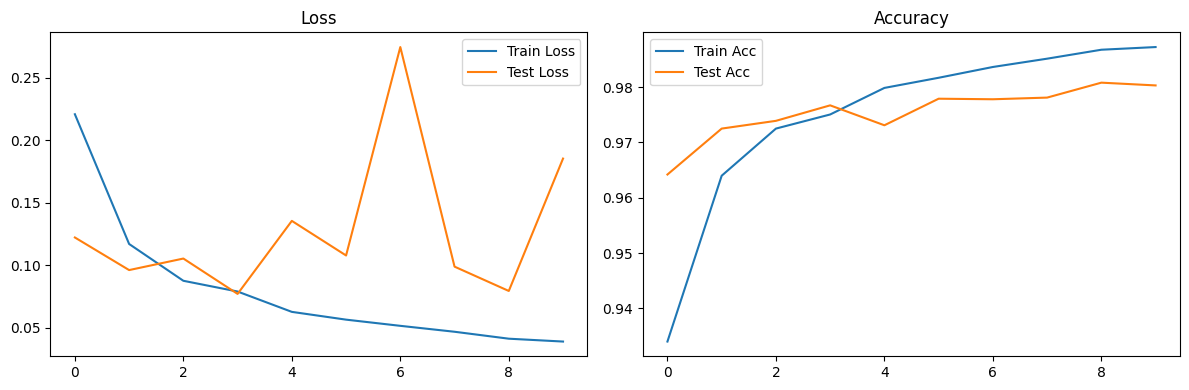

In [10]:
model = FullyConnectedModel(config_path=None, **config_very_big_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

# Анализ выводов 
## Узкие слои

Узкие слои показали себя плохо с ошибками, но хорошо с accuracy (она близка к тренировачным значениям). Неплохая конфигурация, но loss не нравится.

## Средние слои
Средние слои почти зеркалят узкие, разве что acuracy показывает в конце спад верных ответов, но мне кажется с увеличением эпох это поменяется. 

## Большие слои
Большие слои не показали особого отличия от других конфигураций. Разве что большая всего ошибка в отличии от других конфигураций появляется не ближе к 6 эпохе, а сразу со 2-ой.

## Очень большие слои
Почти 1 в 1 как со средними слоями

В итоге можно сказать, что вне зависимости от ширины слоев, качество модели особо меняться не будет (По моим данным такое можно сказать)

По времения как то странно получается. Узкие дольше всех работали, в остально особой закономерности я не увидел

# 2.2 Оптимизация архитектуры

Создание Grid search

In [21]:
import itertools #Эта библиотека выполняет быстрее перебор списков и комбинаций, чем через обычные циклы (По ЕГЭ знаю)

# Параметры для grid search
hidden_sizes = [64, 128, 256, 512] # базовые размеры скрытых слоёв
num_layers_list = [1, 2, 3] # Число слоёв
schemes = ['narrowing', 'constant', 'widening']  # Схемы изменения ширины

param_grid = list(itertools.product(hidden_sizes, num_layers_list, schemes))# генерируем все возможные комбинации

Функция для генерации конфигураций на основе схемы, которые были созданы ранее

In [22]:
def generate_config(input_size=784, num_classes=10, hidden_size=256, num_layers=2, scheme='constant'):
    layers = []
    if scheme == 'narrowing':
        sizes = [hidden_size // (2**i) for i in range(num_layers)]
    elif scheme == 'widening':
        sizes = [hidden_size * (2**i) for i in range(num_layers)]
    else:
        sizes = [hidden_size] * num_layers

    for size in sizes:
        layers.append({"type": "linear", "size": size})
        layers.append({"type": "relu"})
        layers.append({"type": "batch_norm"})
        layers.append({"type": "dropout", "rate": 0.4})

    return {
        "input_size": input_size,
        "num_classes": num_classes,
        "layers": layers
    }

Запуск grid search

In [23]:
import time

results = []
print(f'{len(param_grid)} возможных комбинаций')
param_grid = param_grid[:6] # сокращу, так как уже очень долго жду, 15 комбинаций прождал 40мин
print(f'{len(param_grid)} Сокращенное количество')

for hidden_size, num_layers, scheme in tqdm(param_grid):
    config = generate_config(hidden_size=hidden_size, num_layers=num_layers, scheme=scheme)
    
    model = FullyConnectedModel(config_path=None, **config).to(device)
    
    start_time = time.time()
    #Я уменьшил историю количество эпох, так как иначе буду очень долго ждать, я для задания раньше использвал 10 для более
    #Корректного анализа графиков (по 3-ем эпохам трудно что то сказать)
    history = train_model(model, train_loader, test_loader, epochs=3, device=device) 
    training_time = time.time() - start_time
    
    best_test_acc = max(history['test_accs'])
    
    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'scheme': scheme,
        'best_test_acc': best_test_acc,
        'training_time': training_time
    })

36 возможных комбинаций
6 Сокращенное количество


 22%|█████████████████▍                                                              | 205/938 [00:08<00:31, 23.04it/s]


 45%|███████████████████████████████████▊                                            | 420/938 [00:16<00:21, 24.31it/s]


 63%|██████████████████████████████████████████████████▋                             | 594/938 [00:25<00:20, 16.56it/s]


 84%|██████████████████████████████████████████████████████████████████▉             | 785/938 [00:34<00:06, 24.84it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:42<00:00, 22.11it/s]

  7%|█████▋                                                                           | 11/157 [00:00<00:06, 21.91it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.61it/s]


Epoch 1/3:
Train Loss: 0.3995, Train Acc: 0.8892
Test Loss: 0.2011, Test Acc: 0.9392
--------------------------------------------------



 22%|█████████████████▉                                                              | 210/938 [00:09<00:45, 16.13it/s]


 39%|███████████████████████████████▌                                                | 370/938 [00:20<00:22, 24.88it/s]


 61%|████████████████████████████████████████████████▋                               | 571/938 [00:29<00:14, 25.40it/s]


 84%|██████████████████████████████████████████████████████████████████▉             | 785/938 [00:37<00:06, 22.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:45<00:00, 20.70it/s]

 23%|██████████████████▌                                                              | 36/157 [00:01<00:03, 30.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 31.38it/s]


Epoch 2/3:
Train Loss: 0.2549, Train Acc: 0.9248
Test Loss: 0.1556, Test Acc: 0.9546
--------------------------------------------------



 23%|██████████████████                                                              | 212/938 [00:08<00:29, 24.51it/s]


 51%|████████████████████████████████████████▍                                       | 474/938 [00:16<00:14, 32.20it/s]


 73%|██████████████████████████████████████████████████████████▋                     | 688/938 [00:24<00:10, 24.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.51it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]


 17%|█████████████▊                                                                     | 1/6 [02:16<11:24, 136.92s/it]

Epoch 3/3:
Train Loss: 0.2265, Train Acc: 0.9326
Test Loss: 0.1338, Test Acc: 0.9594
--------------------------------------------------



 27%|█████████████████████▍                                                          | 251/938 [00:07<00:21, 32.49it/s]


 51%|████████████████████████████████████████▋                                       | 477/938 [00:16<00:21, 21.44it/s]


 73%|██████████████████████████████████████████████████████████▏                     | 682/938 [00:24<00:10, 24.89it/s]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 883/938 [00:32<00:01, 27.52it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:34<00:00, 27.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.43it/s]


Epoch 1/3:
Train Loss: 0.4068, Train Acc: 0.8872
Test Loss: 0.2000, Test Acc: 0.9408
--------------------------------------------------



 25%|███████████████████▊                                                            | 233/938 [00:07<00:28, 24.54it/s]


 51%|████████████████████████████████████████▊                                       | 478/938 [00:16<00:14, 32.51it/s]


 76%|████████████████████████████████████████████████████████████▉                   | 714/938 [00:24<00:09, 24.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.78it/s]

 13%|██████████▎                                                                      | 20/157 [00:00<00:04, 32.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 35.49it/s]


Epoch 2/3:
Train Loss: 0.2568, Train Acc: 0.9239
Test Loss: 0.1564, Test Acc: 0.9525
--------------------------------------------------



 22%|█████████████████▋                                                              | 207/938 [00:07<00:28, 25.80it/s]


 49%|██████████████████████████████████████▉                                         | 456/938 [00:16<00:14, 33.28it/s]


 72%|█████████████████████████████████████████████████████████▋                      | 676/938 [00:24<00:08, 30.48it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.92it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]


 33%|███████████████████████████▋                                                       | 2/6 [04:09<08:11, 122.83s/it]

Epoch 3/3:
Train Loss: 0.2291, Train Acc: 0.9323
Test Loss: 0.1295, Test Acc: 0.9617
--------------------------------------------------



 27%|█████████████████████▉                                                          | 257/938 [00:08<00:20, 34.03it/s]


 51%|████████████████████████████████████████▌                                       | 476/938 [00:16<00:17, 27.17it/s]


 79%|██████████████████████████████████████████████████████████████▉                 | 738/938 [00:24<00:06, 31.40it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.71it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:04, 28.12it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.28it/s]


Epoch 1/3:
Train Loss: 0.4030, Train Acc: 0.8873
Test Loss: 0.1881, Test Acc: 0.9431
--------------------------------------------------



 25%|███████████████████▌                                                            | 230/938 [00:08<00:38, 18.23it/s]


 46%|████████████████████████████████████▍                                           | 427/938 [00:17<00:19, 26.02it/s]


 71%|████████████████████████████████████████████████████████▍                       | 662/938 [00:25<00:11, 24.68it/s]


 96%|█████████████████████████████████████████████████████████████████████████████   | 903/938 [00:33<00:01, 33.50it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:34<00:00, 27.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.12it/s]


Epoch 2/3:
Train Loss: 0.2543, Train Acc: 0.9236
Test Loss: 0.1542, Test Acc: 0.9526
--------------------------------------------------



 23%|██████████████████▏                                                             | 213/938 [00:08<00:24, 29.75it/s]


 47%|█████████████████████████████████████▊                                          | 443/938 [00:16<00:20, 24.72it/s]


 68%|██████████████████████████████████████████████████████▋                         | 641/938 [00:25<00:12, 23.86it/s]


 90%|████████████████████████████████████████████████████████████████████████        | 845/938 [00:34<00:04, 20.74it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:38<00:00, 24.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 144/157 [00:04<00:00, 33.95it/s]


 50%|█████████████████████████████████████████▌                                         | 3/6 [06:08<06:03, 121.04s/it]

Epoch 3/3:
Train Loss: 0.2189, Train Acc: 0.9351
Test Loss: 0.1277, Test Acc: 0.9593
--------------------------------------------------



 24%|██████████████████▉                                                             | 222/938 [00:08<00:33, 21.41it/s]


 51%|████████████████████████████████████████▌                                       | 476/938 [00:16<00:14, 31.35it/s]


 74%|███████████████████████████████████████████████████████████▎                    | 696/938 [00:25<00:09, 26.81it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:33<00:00, 28.28it/s]

 10%|████████▎                                                                        | 16/157 [00:00<00:03, 35.39it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.16it/s]


Epoch 1/3:
Train Loss: 0.5858, Train Acc: 0.8375
Test Loss: 0.2089, Test Acc: 0.9347
--------------------------------------------------



 24%|███████████████████                                                             | 223/938 [00:08<00:30, 23.28it/s]


 45%|███████████████████████████████████▊                                            | 420/938 [00:17<00:29, 17.72it/s]


 69%|██████████████████████████████████████████████████████▉                         | 644/938 [00:25<00:09, 30.32it/s]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 870/938 [00:34<00:02, 22.80it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:36<00:00, 25.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.88it/s]


Epoch 2/3:
Train Loss: 0.3520, Train Acc: 0.8986
Test Loss: 0.1673, Test Acc: 0.9491
--------------------------------------------------



 24%|███████████████████▎                                                            | 227/938 [00:08<00:30, 23.04it/s]


 51%|████████████████████████████████████████▋                                       | 477/938 [00:16<00:14, 31.11it/s]


 75%|███████████████████████████████████████████████████████████▌                    | 699/938 [00:25<00:10, 23.31it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:33<00:00, 28.18it/s]

  8%|██████▋                                                                          | 13/157 [00:00<00:05, 26.31it/s]


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [08:07<04:00, 120.14s/it]

Epoch 3/3:
Train Loss: 0.3131, Train Acc: 0.9100
Test Loss: 0.1549, Test Acc: 0.9543
--------------------------------------------------



 25%|███████████████████▊                                                            | 233/938 [00:08<00:23, 30.23it/s]


 49%|███████████████████████████████████████▏                                        | 459/938 [00:16<00:21, 21.93it/s]


 75%|████████████████████████████████████████████████████████████▏                   | 706/938 [00:25<00:07, 31.31it/s]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 932/938 [00:33<00:00, 23.01it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:33<00:00, 27.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.96it/s]


Epoch 1/3:
Train Loss: 0.4953, Train Acc: 0.8566
Test Loss: 0.2205, Test Acc: 0.9320
--------------------------------------------------



 24%|███████████████████▍                                                            | 228/938 [00:08<00:31, 22.52it/s]


 49%|███████████████████████████████████████▏                                        | 459/938 [00:16<00:16, 29.63it/s]


 73%|██████████████████████████████████████████████████████████▌                     | 687/938 [00:25<00:11, 22.71it/s]


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 921/938 [00:33<00:00, 29.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:34<00:00, 27.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.71it/s]


Epoch 2/3:
Train Loss: 0.3090, Train Acc: 0.9094
Test Loss: 0.1655, Test Acc: 0.9492
--------------------------------------------------



 23%|██████████████████▋                                                             | 219/938 [00:08<00:22, 31.90it/s]


 50%|████████████████████████████████████████▎                                       | 472/938 [00:16<00:21, 21.86it/s]


 74%|███████████████████████████████████████████████████████████                     | 693/938 [00:25<00:07, 32.00it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:33<00:00, 28.00it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [10:04<01:58, 118.92s/it]

Epoch 3/3:
Train Loss: 0.2710, Train Acc: 0.9203
Test Loss: 0.1401, Test Acc: 0.9569
--------------------------------------------------



 25%|████████████████████▏                                                           | 236/938 [00:07<00:23, 30.21it/s]


 44%|███████████████████████████████████                                             | 411/938 [00:16<00:24, 21.19it/s]


 66%|█████████████████████████████████████████████████████                           | 622/938 [00:25<00:13, 23.72it/s]


 86%|████████████████████████████████████████████████████████████████████▍           | 802/938 [00:34<00:06, 21.46it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:40<00:00, 23.19it/s]

 32%|█████████████████████████▊                                                       | 50/157 [00:02<00:06, 15.97it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.88it/s]


Epoch 1/3:
Train Loss: 0.4595, Train Acc: 0.8616
Test Loss: 0.1851, Test Acc: 0.9425
--------------------------------------------------



 25%|████████████████████▏                                                           | 237/938 [00:08<00:38, 18.22it/s]


 46%|█████████████████████████████████████▏                                          | 436/938 [00:17<00:16, 30.82it/s]


 73%|██████████████████████████████████████████████████████████                      | 681/938 [00:25<00:13, 18.94it/s]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 886/938 [00:34<00:01, 31.83it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:35<00:00, 26.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 32.16it/s]


Epoch 2/3:
Train Loss: 0.2943, Train Acc: 0.9115
Test Loss: 0.1449, Test Acc: 0.9567
--------------------------------------------------



 22%|█████████████████▉                                                              | 211/938 [00:08<00:25, 28.39it/s]


 44%|███████████████████████████████████▎                                            | 414/938 [00:16<00:25, 20.49it/s]


 64%|███████████████████████████████████████████████████▏                            | 600/938 [00:25<00:15, 22.04it/s]


 84%|███████████████████████████████████████████████████████████████████▍            | 791/938 [00:34<00:07, 18.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:40<00:00, 23.00it/s]

 34%|███████████████████████████▊                                                     | 54/157 [00:01<00:03, 25.87it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [12:20<00:00, 123.40s/it]

Epoch 3/3:
Train Loss: 0.2537, Train Acc: 0.9232
Test Loss: 0.1271, Test Acc: 0.9596
--------------------------------------------------


Heatmap визуализация

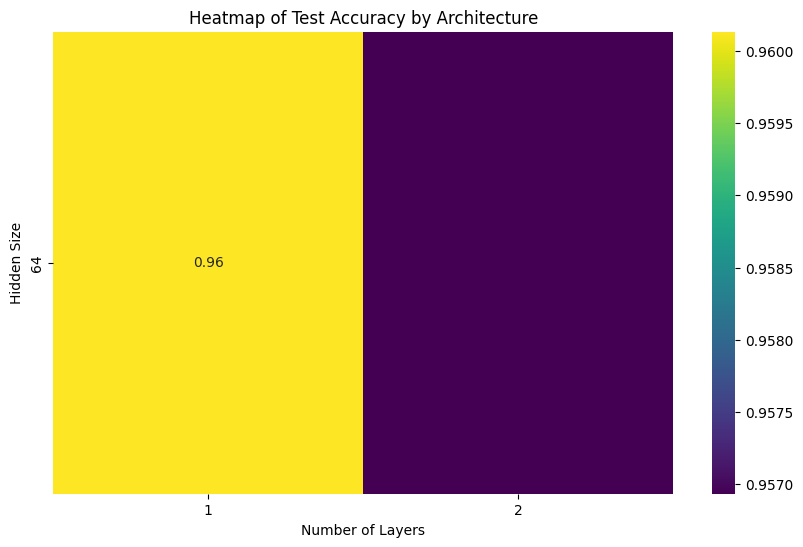

In [24]:
import pandas as pd #Решил преобразовать все в Датафрейм для работы с Seaborn-ом 
df_results = pd.DataFrame(results)
# print(df_results.sort_values(by='best_test_acc').head())
import seaborn as sns
import matplotlib.pyplot as plt

# Создаём сводную таблицу для heatmap
heatmap_data = df_results.pivot_table(
    index='hidden_size', 
    columns='num_layers', 
    values='best_test_acc'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("Heatmap of Test Accuracy by Architecture")
plt.xlabel("Number of Layers")
plt.ylabel("Hidden Size")
plt.show()

# Итог по grid search

На графике видно, что самую высокую точность показывает простая модель с 1 скрытым слоем и 64 нейронами. Более глубокие или широкие архитектуры демонстрируют чуть меньшую точность, что может говорить о переобучении или излишней сложности модели. Для задачи распознавания MNIST такие усложнённые сети не дают преимущества по сравнению с простыми. Это значит, что оптимальной для этих данных будет модель с минимальным числом слоёв и умеренным количеством нейронов. ОДНАКО СТОИТ УЧИТЫВАТЬ, ЧТО Я НЕ ВСЕ ВАРИАНТЫ РАССМОТРЕЛ, А ТОЛЬКО 6 ИЗ 36 ОБНОРУЖЕННЫХ. 

# Сужение и Равномерные конфигурации
по-идее в предыдущем задании я уже рассмотрел данный случай, но проверю более привычным способом

Model parameters: 1240298


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.37it/s]


Epoch 1/10:
Train Loss: 0.2083, Train Acc: 0.9363
Test Loss: 0.1115, Test Acc: 0.9650
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.15it/s]


Epoch 2/10:
Train Loss: 0.1150, Train Acc: 0.9645
Test Loss: 0.1317, Test Acc: 0.9707
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.31it/s]


Epoch 3/10:
Train Loss: 0.0878, Train Acc: 0.9728
Test Loss: 0.1593, Test Acc: 0.9714
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.40it/s]


Epoch 4/10:
Train Loss: 0.0756, Train Acc: 0.9761
Test Loss: 0.0986, Test Acc: 0.9777
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.81it/s]


Epoch 5/10:
Train Loss: 0.0579, Train Acc: 0.9815
Test Loss: 0.0875, Test Acc: 0.9787
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 33.51it/s]


Epoch 6/10:
Train Loss: 0.0567, Train Acc: 0.9816
Test Loss: 0.1423, Test Acc: 0.9767
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.77it/s]


Epoch 7/10:
Train Loss: 0.0510, Train Acc: 0.9840
Test Loss: 0.1368, Test Acc: 0.9778
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 30.39it/s]


Epoch 8/10:
Train Loss: 0.0462, Train Acc: 0.9850
Test Loss: 0.1375, Test Acc: 0.9785
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.84it/s]


Epoch 9/10:
Train Loss: 0.0412, Train Acc: 0.9865
Test Loss: 0.2763, Test Acc: 0.9787
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 34.23it/s]


Epoch 10/10:
Train Loss: 0.0388, Train Acc: 0.9870
Test Loss: 0.1626, Test Acc: 0.9811
--------------------------------------------------
{'train_losses': [0.2083458200381048, 0.11497173061681741, 0.08784913029601134, 0.07555293581505089, 0.05785686318933376, 0.0566559666065253, 0.05098909698079215, 0.04624146310572099, 0.04118328555631685, 0.03879592626660962], 'train_accs': [0.9362666666666667, 0.9644833333333334, 0.9728166666666667, 0.9761333333333333, 0.9815333333333334, 0.9815833333333334, 0.9839833333333333, 0.9850166666666667, 0.9864666666666667, 0.9870166666666667], 'test_losses': [0.11146473291642953, 0.13167288791811668, 0.1593022737001398, 0.09861576810425313, 0.08745884431076902, 0.1423342337782939, 0.13678913742857765, 0.1375150391955355, 0.27629399496236234, 0.16262620298940206], 'test_accs': [0.965, 0.9707, 0.9714, 0.9777, 0.9787, 0.9767, 0.9778, 0.9785, 0.9787, 0.9811]}
565.6009588241577


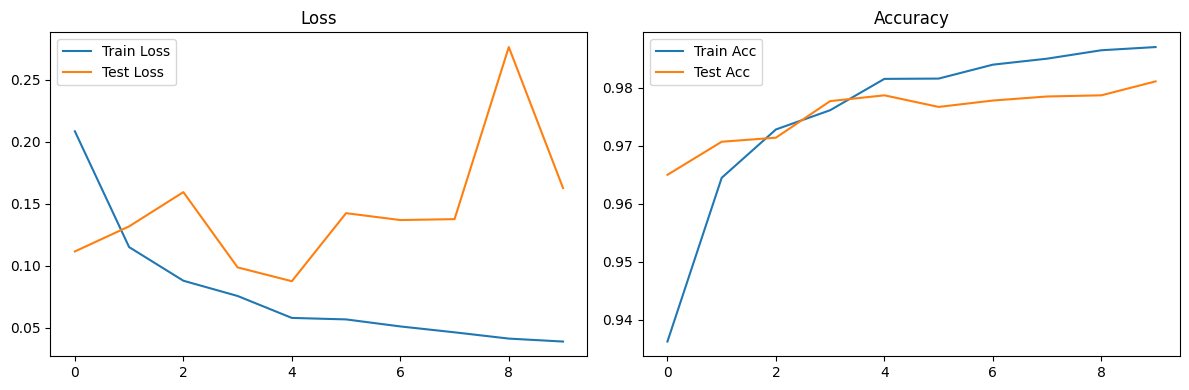

In [25]:
model = FullyConnectedModel(config_path=None, **config_evenly_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

Model parameters: 5364850


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.66it/s]


Epoch 1/10:
Train Loss: 0.2642, Train Acc: 0.9267
Test Loss: 0.1514, Test Acc: 0.9573
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.64it/s]


Epoch 2/10:
Train Loss: 0.1328, Train Acc: 0.9607
Test Loss: 0.1292, Test Acc: 0.9644
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.53it/s]


Epoch 3/10:
Train Loss: 0.1001, Train Acc: 0.9702
Test Loss: 0.1677, Test Acc: 0.9700
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.67it/s]


Epoch 4/10:
Train Loss: 0.0867, Train Acc: 0.9739
Test Loss: 0.3366, Test Acc: 0.9713
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.90it/s]


Epoch 5/10:
Train Loss: 0.0743, Train Acc: 0.9776
Test Loss: 0.2491, Test Acc: 0.9727
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.78it/s]


Epoch 6/10:
Train Loss: 0.0638, Train Acc: 0.9802
Test Loss: 0.1941, Test Acc: 0.9755
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.98it/s]


Epoch 7/10:
Train Loss: 0.0594, Train Acc: 0.9821
Test Loss: 0.1869, Test Acc: 0.9771
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.81it/s]


Epoch 8/10:
Train Loss: 0.0532, Train Acc: 0.9841
Test Loss: 0.3936, Test Acc: 0.9750
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.11it/s]


Epoch 9/10:
Train Loss: 0.0462, Train Acc: 0.9864
Test Loss: 0.2359, Test Acc: 0.9785
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.53it/s]


Epoch 10/10:
Train Loss: 0.0454, Train Acc: 0.9866
Test Loss: 0.5140, Test Acc: 0.9765
--------------------------------------------------
{'train_losses': [0.26422896314420297, 0.13283266808672833, 0.10008051680541957, 0.0867151663861305, 0.07434629169889717, 0.06380828841856724, 0.05937236043890051, 0.05320883641244537, 0.0461625928419419, 0.045422942254168326], 'train_accs': [0.9267166666666666, 0.9607, 0.9702333333333333, 0.9739166666666667, 0.9775833333333334, 0.98025, 0.9820666666666666, 0.9841333333333333, 0.9864166666666667, 0.9866], 'test_losses': [0.15143999029792532, 0.129236644418661, 0.16772530830948992, 0.3365705131077535, 0.2491161645709187, 0.19412540289360236, 0.1868658414993319, 0.39363532983772775, 0.23590510356371738, 0.513994080456278], 'test_accs': [0.9573, 0.9644, 0.97, 0.9713, 0.9727, 0.9755, 0.9771, 0.975, 0.9785, 0.9765]}
1028.6572635173798


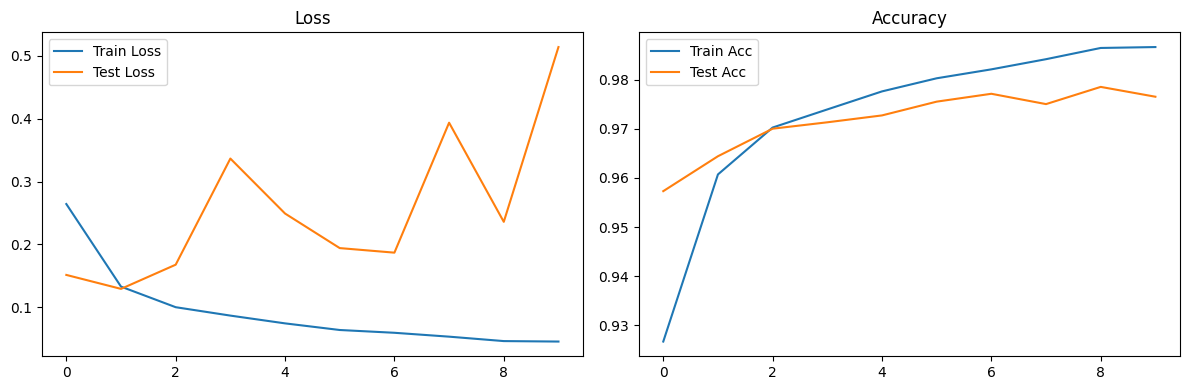

In [26]:
model = FullyConnectedModel(config_path=None, **config_extension_layer)

print(f"Model parameters: {count_parameters(model)}")
start = time.time()
history = train_model(model, train_loader, test_loader, epochs=10, device=str(device))

print(history)
plot_training_history(history)
end = time.time() - start
print(end)

В равномерном ширине слоев качестве параметров все также очень похожи. Самая большая ошибка совершина в 8 эпохе.

В возрастающей ширине слоев самый худший результат с loss и accurcy тоже падает. Плохо